# Replication of Newman *et al.* (2015) *in-vitro* optoclamp

*(last run with Cleo v0.18.1. To get the final figure, you'll need to rerun the notebook twice, with `alternate_experiment` set to both `True` and `False`. Sorry this got to be too cumbersome for a notebook. Snakemake, Task, or doit would have been better for running a bunch of experiments in parallel.)*

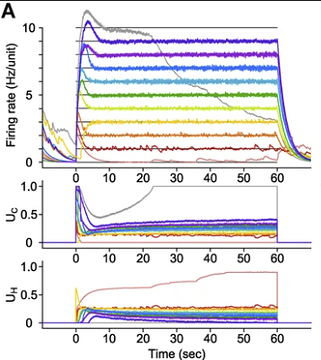

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import brian2 as b2
import cleo

b2.prefs.codegen.target = "cython"
b2.seed(19181211)
rng = np.random.default_rng(19181211)
cleo.utilities.style_plots_for_paper()
cleo.utilities.set_seed(20080803)

In [2]:
exc_wavelength = 465 * b2.nmeter
inh_wavelength = 590 * b2.nmeter
med_rho_rel_exc = 0.3
med_rho_rel_inh = 0.001
exc_opsin = cleo.opto.chr2_h134r_4s()
# Ensure no response to inhibitory wavelength, otherwise a tiny bit leaks in from interpolating between 1P and 2P ranges.
# This would be the right thing to do, except we aren't confident in the 2P action spectra yet (as of v0.18.1)
exc_opsin.spectrum.insert(8, (inh_wavelength / b2.nmeter, 0.0))
inh_opsin = cleo.opto.enphr3_3s()
results_path = "results/newman15"
amp_UC = 13.2
amp_UH = 11.8
exc_pulse_freq_range = 10

alternate_experiment = True
if alternate_experiment:
    exc_wavelength = 590 * b2.nmeter
    inh_wavelength = 450 * b2.nmeter
    med_rho_rel_inh = 0.3
    exc_opsin = cleo.opto.chrimson_4s()
    exc_opsin.extrapolate = True
    inh_opsin = cleo.opto.gtacr2_4s()
    results_path = "results/newman15-alt"
    amp_UH = 0.0005
    exc_pulse_freq_range = 50

os.makedirs(results_path, exist_ok=True)

## Balanced E/I network
from [Neuronal Dynamics](https://neuronaldynamics-exercises.readthedocs.io/en/latest/_modules/neurodynex3/brunel_model/LIF_spiking_network.html#simulate_brunel_network)

In [3]:
from random import sample

b2.defaultclock.dt = 0.2 * b2.ms

N_Excit = 800
N_Inhib = None  # None = N_Excit / 4
N_extern = 1000
connection_probability = 0.1
w0 = 0.78 * b2.mV
g = 7.5
synaptic_delay = 1.5 * b2.ms
poisson_input_rate = 8.2 * b2.Hz
w_external = None
w_external = 0.1 * b2.mV
v_rest = -70 * b2.mV
v_reset = -60 * b2.mV
firing_threshold = -50 * b2.mV
membrane_time_scale = 20 * b2.ms
Rm = 100 * b2.Mohm
abs_refractory_period = 2 * b2.ms
monitored_subset_size = 100
random_vm_init = True
"""
Fully parametrized implementation of a sparsely connected network of LIF neurons (Brunel 2000)

Args:
    N_Excit (int): Size of the excitatory popluation
    N_Inhib (int): optional. Size of the inhibitory population.
        If not set (=None), N_Inhib is set to N_excit/4.
    N_extern (int): optional. Number of presynaptic excitatory poisson neurons. Note: if set to a value,
        this number does NOT depend on N_Excit and NOT depend on connection_probability (this is different
        from the book and paper. Only if N_extern is set to 'None', then N_extern is computed as
        N_Excit*connection_probability.
    connection_probability (float): probability to connect to any of the (N_Excit+N_Inhib) neurons
        CE = connection_probability*N_Excit
        CI = connection_probability*N_Inhib
        Cexternal = N_extern
    w0 (float): Synaptic strength J
    g (float): relative importance of inhibition. J_exc = w0. J_inhib = -g*w0
    synaptic_delay (Quantity): Delay between presynaptic spike and postsynaptic increase of v_m
    poisson_input_rate (Quantity): Poisson rate of the external population
    w_external (float): optional. Synaptic weight of the excitatory external poisson neurons onto all
        neurons in the network. Default is None, in that case w_external is set to w0, which is the
        standard value in the book and in the paper Brunel2000.
        The purpose of this parameter is to see the effect of external input in the
        absence of network feedback(setting w0 to 0mV and w_external>0).
    v_rest (Quantity): Resting potential
    v_reset (Quantity): Reset potential
    firing_threshold (Quantity): Spike threshold
    membrane_time_scale (Quantity): tau_m
    abs_refractory_period (Quantity): absolute refractory period, tau_ref
    monitored_subset_size (int): nr of neurons for which a VoltageMonitor is recording Vm
    random_vm_init (bool): if true, the membrane voltage of each neuron is initialized with a
        random value drawn from Uniform(v_rest, firing_threshold)
    sim_time (Quantity): Simulation time

Returns:
    (rate_monitor, spike_monitor, voltage_monitor, idx_monitored_neurons)
    PopulationRateMonitor: Rate Monitor
    SpikeMonitor: SpikeMonitor for ALL (N_Excit+N_Inhib) neurons
    StateMonitor: membrane voltage for a selected subset of neurons
    list: index of monitored neurons. length = monitored_subset_size
"""
if N_Inhib is None:
    N_Inhib = int(N_Excit / 4)
if N_extern is None:
    N_extern = int(N_Excit * connection_probability)
if w_external is None:
    w_external = w0

J_excit = w0
J_inhib = -g * w0

lif_dynamics = """
dv/dt = (-(v-v_rest) + Rm*(Iopto_exc + Iopto_inh)) / membrane_time_scale : volt (unless refractory)
Iopto_exc : amp
Iopto_inh : amp
"""

neurons = b2.NeuronGroup(
    N_Excit + N_Inhib,
    model=lif_dynamics,
    threshold="v>firing_threshold",
    reset="v=v_reset",
    refractory=abs_refractory_period,
    method="linear",
)
if random_vm_init:
    neurons.v = (
        np.random.uniform(
            v_rest / b2.mV, high=firing_threshold / b2.mV, size=(N_Excit + N_Inhib)
        )
        * b2.mV
    )
else:
    neurons.v = v_rest
excitatory_population = neurons[:N_Excit]
inhibitory_population = neurons[N_Excit:]

exc_synapses = b2.Synapses(
    excitatory_population,
    target=neurons,
    on_pre="v += J_excit",
    delay=synaptic_delay,
)
exc_synapses.connect(p=connection_probability)

inhib_synapses = b2.Synapses(
    inhibitory_population,
    target=neurons,
    on_pre="v += J_inhib",
    delay=synaptic_delay,
)
inhib_synapses.connect(p=connection_probability)

external_poisson_input = b2.PoissonInput(
    target=neurons,
    target_var="v",
    N=N_extern,
    rate=poisson_input_rate,
    weight=w_external,
)

# collect data of a subset of neurons:
monitored_subset_size = min(monitored_subset_size, (N_Excit + N_Inhib))
idx_monitored_neurons = sample(range(N_Excit + N_Inhib), monitored_subset_size)
# rate_monitor = b2.PopulationRateMonitor(neurons)
# record= some_list is not supported? :-(
# spike_monitor = b2.SpikeMonitor(neurons, record=idx_monitored_neurons)
# voltage_monitor = b2.StateMonitor(neurons, "v", record=idx_monitored_neurons)

net = b2.Network(
    neurons,
    exc_synapses,
    inhib_synapses,
    external_poisson_input,
    # rate_monitor,
    # spike_monitor,
    # voltage_monitor,
)

# net.run(3 * b2.second)
# plt.scatter(spike_monitor.t / b2.ms, spike_monitor.i, s=0.5)
# plt.xlim(0, 10000)

In [4]:
sim = cleo.CLSimulator(net)

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='x (mm)', ylabel='y (mm)', zlabel='z (mm)'>)

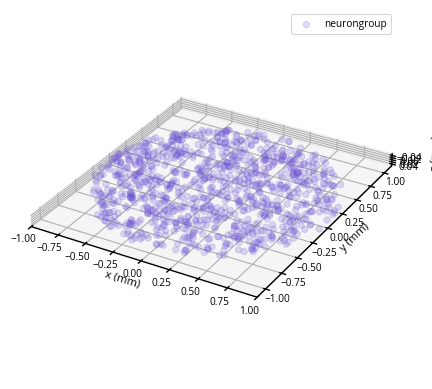

In [5]:
cleo.coords.assign_coords_rand_cylinder(neurons, [0, 0, 0], [0, 0, 0], 1)
cleo.viz.plot(neurons, xlim=[-1, 1], axis_scale_unit=b2.mm)

## Multi-electrode array (MEA)
Spacing appears to be 200 μm.

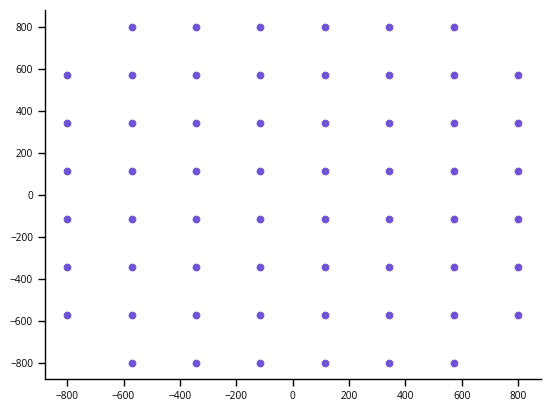

In [6]:
space = 200 * b2.um
n_side = 8
radius = space * n_side / 2
x, y = np.meshgrid(
    np.linspace(-radius, radius, n_side), np.linspace(-radius, radius, n_side)
)
y.shape
xy = np.column_stack([x.ravel(), y.ravel()]) * b2.meter
xy = np.delete(xy, [0, n_side - 1, -n_side, -1], 0) * b2.meter
plt.scatter(xy[:, 0] / b2.um, xy[:, 1] / b2.um)
# xy

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='x (um)', ylabel='y (um)', zlabel='z (um)'>)

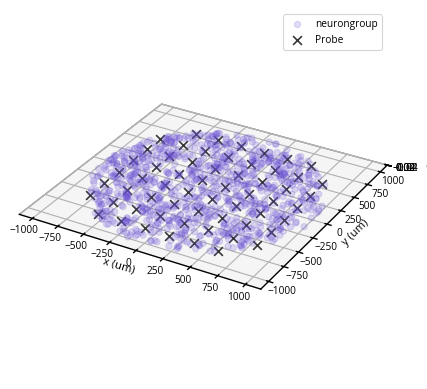

In [7]:
xyz = np.column_stack([xy, np.zeros(xy.shape[0])]) * b2.meter
# before Cleo v0.18 r_half_detection was 80 um
# to get similar 50% detection at 80 um, we set
# r_nf = 2 * r_half_detection + r0
spikes = cleo.ephys.SortedSpiking(r_noise_floor=165 * b2.um)
probe = cleo.ephys.Probe(coords=xyz, signals=[spikes])
sim.inject(probe, neurons)
cleo.viz.plot(neurons, devices=[probe])

WARNING    /home/kyle/GaTech Dropbox/Kyle Johnsen/projects/cleo/cleo/ephys/spiking.py:575: RuntimeWarning: overflow encountered in exp
  collision_prob_fn: Callable[[Quantity], float] = lambda t: 0.2 * np.exp(
 [py.warnings]
WARNING    /home/kyle/GaTech Dropbox/Kyle Johnsen/projects/cleo/cleo/ephys/spiking.py:446: RuntimeWarning: invalid value encountered in multiply
  collision_prob = self.collision_prob_fn(t_diff) * same_chan
 [py.warnings]


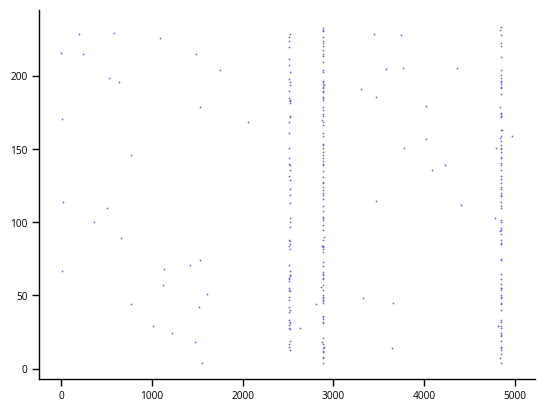

In [8]:
# sigma_ext = 0.05
# neurons.w_external_factor = rng.lognormal(0, sigma_ext, neurons.N) / np.exp(sigma_ext**2 / 2)
# plt.figure()
# plt.hist(neurons.w_external_factor)
# print(np.exp(sigma_ext**2 / 2))
# neurons.w_external_factor = 1
# w_external = 0.1 * b2.mV
# w0 = 0.78 * b2.mV
# w0 = 0 * b2.mV
# J_excit = w0
# J_inhib = -g * w0
sim.set_io_processor(cleo.ioproc.RecordOnlyProcessor(sample_period=1 * b2.ms))
sim.run(5 * b2.second)
plt.figure()
plt.scatter(spikes.t / b2.ms, spikes.i, s=0.2)
sim.reset()
# plt.xlim(0, 10000)

## Optogenetics

In [9]:
exc_light = cleo.light.Light(
    name="exc light",
    coords=[0, 0, -100] * b2.um,
    light_model=cleo.light.KoehlerBeam(radius=1 * b2.mm),
    wavelength=exc_wavelength,
)
sim.inject(exc_light, neurons)
sigma_expr = 0.2
sim.inject(
    exc_opsin,
    neurons,
    Iopto_var_name="Iopto_exc",
    rho_rel=med_rho_rel_exc
    * rng.lognormal(0, sigma_expr, neurons.N)
    / np.exp(sigma_expr**2 / 2),
)

inh_light = cleo.light.Light(
    name="inh light",
    coords=[0, 0, -250] * b2.um,
    light_model=cleo.light.KoehlerBeam(radius=1 * b2.mm),
    wavelength=inh_wavelength,
)
sim.inject(inh_light, neurons)
sim.inject(
    inh_opsin,
    neurons,
    Iopto_var_name="Iopto_inh",
    rho_rel=med_rho_rel_inh
    * rng.lognormal(0, sigma_expr, neurons.N)
    / np.exp(sigma_expr**2 / 2),
)

WARNING    /home/kyle/GaTech Dropbox/Kyle Johnsen/projects/cleo/cleo/light/light_dependence.py:139: UserWarning: λ = 450.0 nm is outside the range of the action spectrum data for Chrimson. Extrapolating: ε = 0.259.
  warnings.warn(
 [py.warnings]
WARNING    The object 'light_prop_Chrimson_neurongroup' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File '/home/kyle/GaTech Dropbox/Kyle Johnsen/projects/cleo/cleo/registry.py', line 131, in _get_or_create_light_prop_syn
    light_prop_syn = Synapses( [brian2.core.base.unused_brian_object]
WARNING    The object 'light_source' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created

CLSimulator(io_processor=RecordOnlyProcessor(sample_period=1. * msecond, sampling='fixed', processing='parallel'), devices={BansalFourStateOpsin(name='GtACR2', save_history=True, on_pre='', spectrum=[(400, 0.4), (410, 0.49), (420, 0.56), (430, 0.65), (440, 0.82), (450, 0.88), (460, 0.88), (470, 1.0), (480, 0.91), (490, 0.67), (500, 0.41), (510, 0.21), (520, 0.12), (530, 0.06), (540, 0.02), (550, 0.0), (560, 0.0), (800, 1.4793867810610162e-06), (820, 1.8122488067997448e-06), (840, 2.0711414934854227e-06), (860, 2.404003519224151e-06), (880, 3.032742901175083e-06), (900, 3.2546509183342354e-06), (920, 3.2546509183342354e-06), (940, 3.6984669526525404e-06), (960, 3.3656049269138116e-06), (980, 2.4779728582772024e-06), (1000, 1.5163714505875414e-06), (1020, 7.766780600570334e-07), (1040, 4.4381603431830484e-07), (1060, 2.2190801715915242e-07), (1080, 7.39693390530508e-08), (1100, 0.0), (1120, 0.0)], extrapolate=False, required_vars=[('Iopto', amp), ('v', volt)], Gd1=17. * hertz, Gd2=10. * 

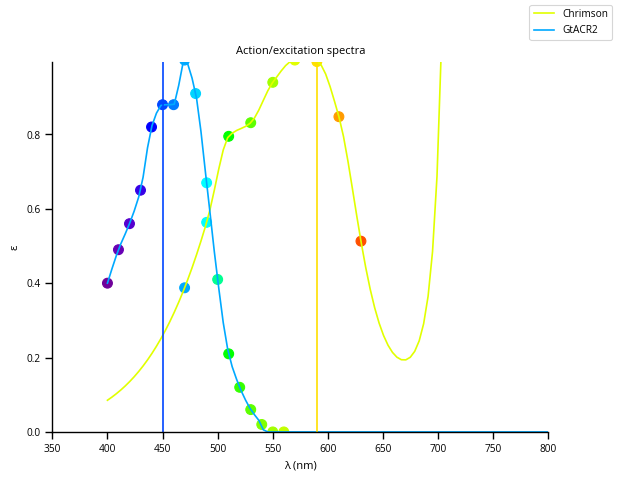

In [10]:
fig, ax = cleo.light.plot_spectra(exc_opsin, inh_opsin, extrapolate=True)
ax.axvline(exc_light.wavelength / b2.nmeter, color=exc_light.color)
ax.axvline(inh_light.wavelength / b2.nmeter, color=inh_light.color)
fig.savefig(os.path.join(results_path, "opsin_spectra.svg"))

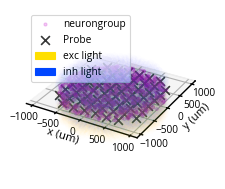

In [11]:
fig, ax = cleo.viz.plot(
    sim=sim, colors=["#c500cc"], figsize=(2.2, 2.2), scatterargs=dict(s=5)
)
ax.set(zticks=[])
# legend above plot
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1))
fig.savefig(f"{results_path}/optoclamp-3d.svg")

## Eyeball test
Trying different levels of stimulation to ensure network activity looks roughly like the following:

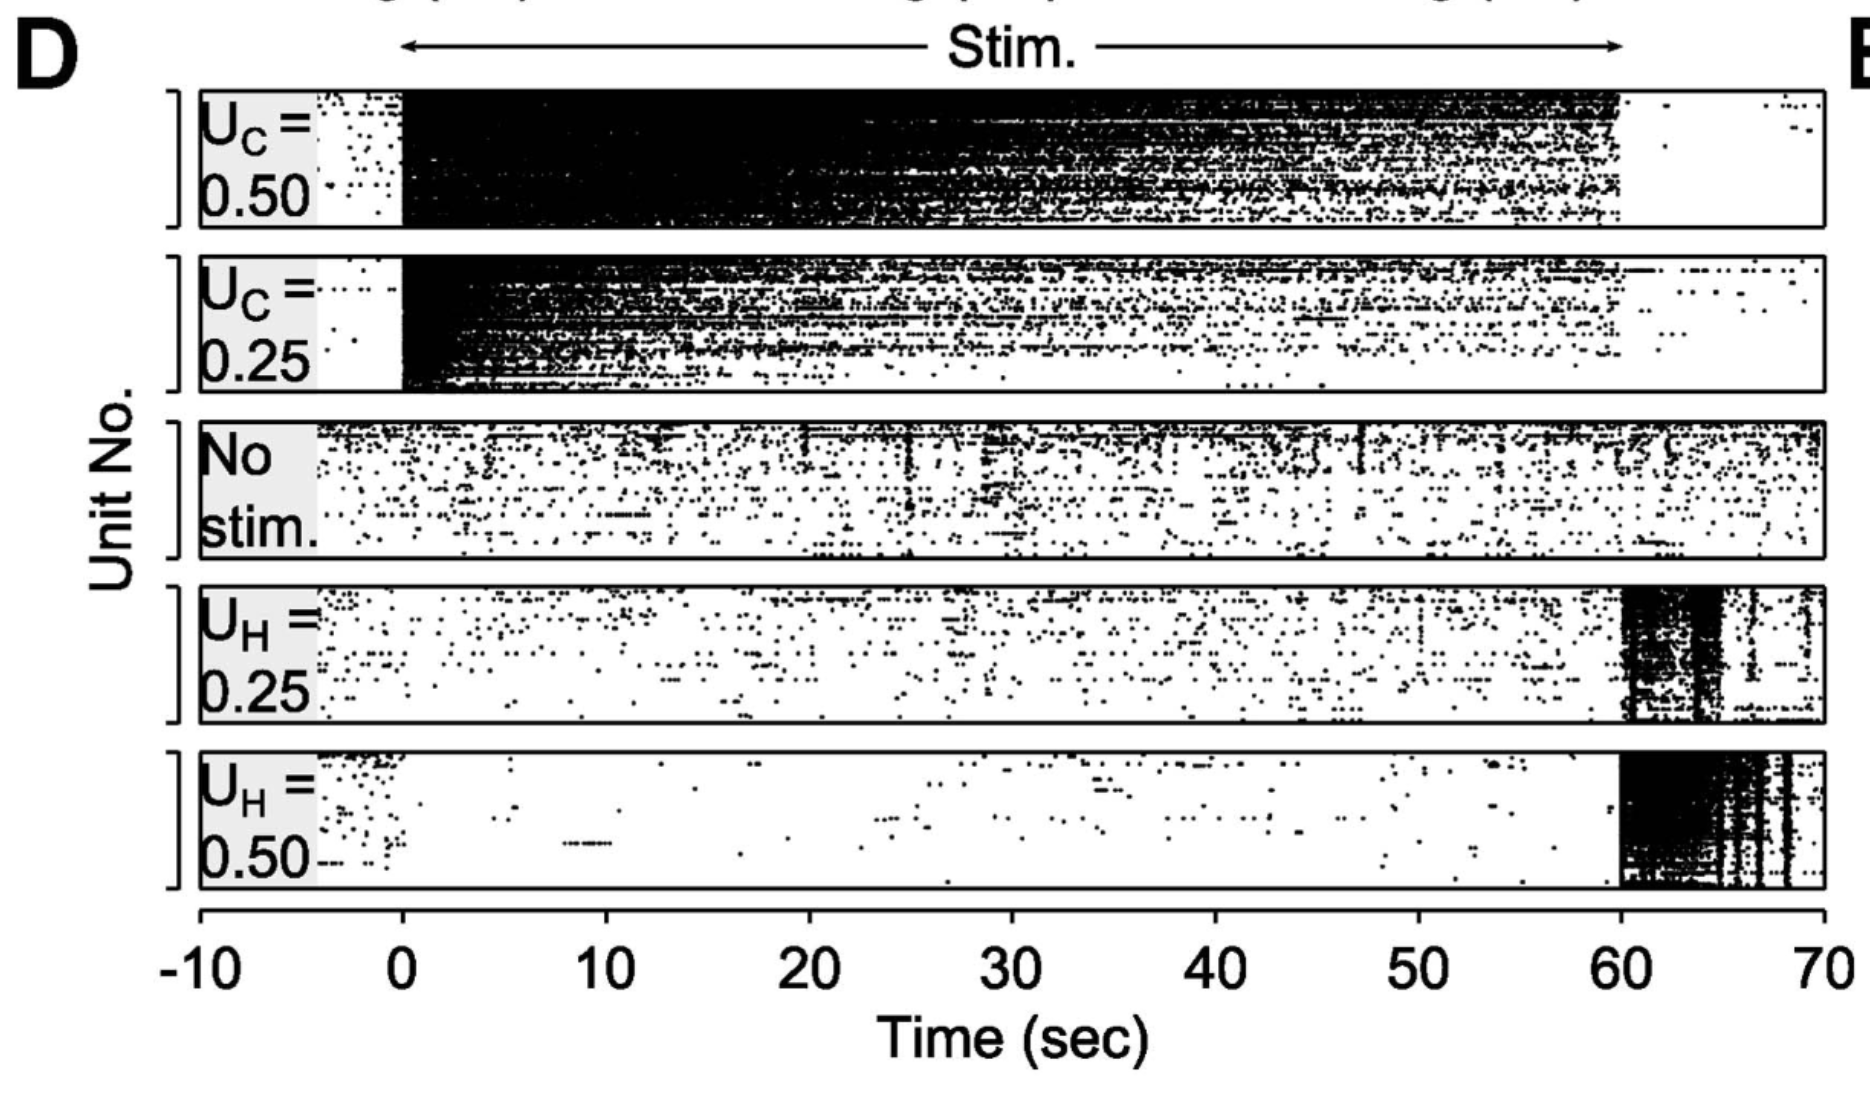

In [12]:
import time

test_length = 9 * b2.second
intrvl = test_length / 9


# define here to reuse
def preprocess_ctrl_signals(latest_ctrl_signals, t):
    out = {}
    UC = latest_ctrl_signals.get("exc light", 0)
    pulse_freq_exc = (exc_pulse_freq_range * UC + 10) * b2.Hz
    pulse_width_exc = 5 * UC * b2.ms
    power_465nm = amp_UC * UC
    on_465nm = t % (1 / pulse_freq_exc) < pulse_width_exc
    out["exc light"] = on_465nm * power_465nm * b2.mwatt / b2.mm2

    UH = latest_ctrl_signals.get("inh light", 0)
    out["inh light"] = UH * amp_UH * b2.mwatt / b2.mm2
    return out


class TestIOProc(cleo.ioproc.LatencyIOProcessor):
    def __init__(self):
        super().__init__(sample_period=1 * b2.ms)
        self.UC_hist = []
        self.UH_hist = []

    def process(self, state_dict, t_samp):
        UC, UH = 0, 0
        if 1 * intrvl <= t_samp < 2 * intrvl:
            UC = 0.5
        elif 3 * intrvl <= t_samp < 4 * intrvl:
            UC = 0.25
        elif 5 * intrvl <= t_samp < 6 * intrvl:
            UH = 0.25
        elif 7 * intrvl <= t_samp < 8 * intrvl:
            UH = 0.5

        self.UC_hist.append(UC)
        self.UH_hist.append(UH)
        stim_values = preprocess_ctrl_signals(
            {"exc light": UC, "inh light": UH}, t_samp
        )
        return stim_values, t_samp

    # def preprocess_ctrl_signals(self, latest_ctrl_signals, t):
    #     ctrl_signals = preprocess_ctrl_signals(latest_ctrl_signals, t)
    #     return ctrl_signals


sim.reset()
test_proc = TestIOProc()
sim.set_io_processor(test_proc)
sim.run(test_length, report="text")

INFO       No numerical integration method specified for group 'syn_Chrimson_neurongroup', using method 'euler' (took 0.03s, trying other methods took 0.05s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'syn_GtACR2_neurongroup', using method 'euler' (took 0.01s, trying other methods took 0.01s). [brian2.stateupdaters.base.method_choice]


Starting simulation at t=0. s for a duration of 9. s


WARNING    /home/kyle/GaTech Dropbox/Kyle Johnsen/projects/cleo/cleo/ephys/spiking.py:575: RuntimeWarning: overflow encountered in exp
  collision_prob_fn: Callable[[Quantity], float] = lambda t: 0.2 * np.exp(
 [py.warnings]
WARNING    /home/kyle/GaTech Dropbox/Kyle Johnsen/projects/cleo/cleo/ephys/spiking.py:446: RuntimeWarning: invalid value encountered in multiply
  collision_prob = self.collision_prob_fn(t_diff) * same_chan
 [py.warnings]
WARNING    /home/kyle/GaTech Dropbox/Kyle Johnsen/projects/cleo/cleo/ephys/spiking.py:450: RuntimeWarning: invalid value encountered in multiply
  collision_prob *= t_diff >= 0
 [py.warnings]


0.6202 s (6%) simulated in 10s, estimated 2m 15s remaining.
1.1592 s (12%) simulated in 20s, estimated 2m 15s remaining.
1.9578 s (21%) simulated in 30s, estimated 1m 48s remaining.
2.8472 s (31%) simulated in 40s, estimated 1m 26s remaining.
3.7372 s (41%) simulated in 50s, estimated 1m 10s remaining.
4.553 s (50%) simulated in 1m 0s, estimated 59s remaining.
5.4504 s (60%) simulated in 1m 10s, estimated 46s remaining.
6.342 s (70%) simulated in 1m 20s, estimated 34s remaining.
7.2032 s (80%) simulated in 1m 30s, estimated 22s remaining.
8.1182 s (90%) simulated in 1m 40s, estimated 11s remaining.
9. s (100%) simulated in 1m 49s


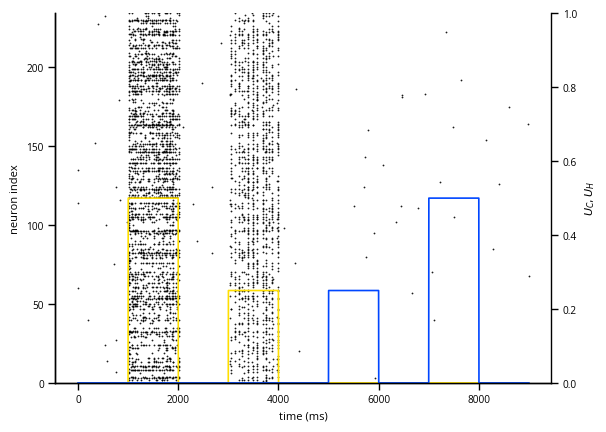

In [13]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.scatter(spikes.t / b2.ms, spikes.i, s=0.2, color="k")
ax.set(ylim=[0, max(spikes.i)], ylabel="neuron index", xlabel="time (ms)")
ax.spines["right"].set_visible(True)
ax2.plot(
    test_proc.t_samp / b2.ms, test_proc.UC_hist, color=exc_light.color, label="$U_C$"
)
ax2.plot(
    test_proc.t_samp / b2.ms, test_proc.UH_hist, color=inh_light.color, label="$U_H$"
)
ax2.set(ylim=[0, 1], ylabel="$U_C, U_H$");

## PI control

In [14]:
import cleo.ioproc


class Controller(cleo.ioproc.LatencyIOProcessor):
    def __init__(self, sample_period=4 * b2.ms):
        super().__init__(sample_period=sample_period)
        self.fr_est_tau = 2500 * b2.ms  # time constant for firing rate estimation
        self.Ts = 0.01 * b2.second  # control period (round-trip time)
        self.Ti = 1 * b2.second  # integral time constant
        self.K = 0.1 / b2.Hz  # proportional gain
        self.u = 0
        self.ef_prev = 0
        self.Δ = 0.25  # overlap between exc and inh stim
        self.uu = []
        self.UCs = []
        self.UHs = []
        self.frs = []
        self.target = 1
        self.timepoints = [10, 20, 80, 90] * b2.second
        # self.timepoints = [1, 2, 3, 4] * b2.second * 5
        # self.timepoints = [2, 7, 22, 27] * b2.second

    def process(self, state_dict, t):
        _, _, spike_counts = state_dict["Probe"]["SortedSpiking"]
        avg_n_spikes = np.mean(spike_counts)
        prev_fr = self.frs[-1] if len(self.frs) > 0 else 0
        fr = cleo.ioproc.exp_firing_rate_estimate(
            avg_n_spikes, self.sample_period, prev_fr, self.fr_est_tau
        )
        self.frs.append(fr)
        if t < self.timepoints[0]:
            UC = 1
            UH = 0
        elif t < self.timepoints[1]:
            UC = 0
            UH = 0
        elif t < self.timepoints[2]:
            ef = self.target - fr  # error in firing rate
            self.u = self.u + self.K * (ef - self.ef_prev + self.Ts / self.Ti * ef)
            self.uu.append(self.u)
            UC = self.u + self.Δ
            UC = np.clip(UC, 0, 1)
            UH = -self.u + self.Δ
            UH = np.clip(UH, 0, 1)
            self.ef_prev = ef
        elif t >= self.timepoints[2]:
            UC = 0
            UH = 0

        self.UCs.append(UC)
        self.UHs.append(UH)

        stim_values = preprocess_ctrl_signals({"exc light": UC, "inh light": UH}, t)
        return stim_values, t + self.Ts

    # def preprocess_ctrl_signals(self, latest_ctrl_signals, t):
    #     return preprocess_ctrl_signals(latest_ctrl_signals, t)


ctrlr = Controller()

In [15]:
def plot_results(t_ms, frs, UCs, UHs, target):
    t = np.array(t_ms) / 1000
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(4, 6))
    axs[0].plot(t, frs)
    axs[0].set(ylabel="firing rate (Hz)")
    axs[0].hlines(target, ctrlr.timepoints[1], ctrlr.timepoints[2])
    axs[1].plot(t, UCs, label="$U_C$", color=exc_light.color)
    axs[1].plot(t, UHs, label="$U_H$", color=inh_light.color)
    axs[1].set(ylabel="$U_C,U_H$", xlabel="time (s)")
    axs[1].legend()
    display(fig)
    plt.close(fig)

In [16]:
results = {}

target = 0
Starting simulation at t=0. s for a duration of 90. s
11.4036 s (12%) simulated in 1m 0s, estimated 6m 54s remaining.
22.9482 s (25%) simulated in 2m 0s, estimated 5m 51s remaining.
33.9902 s (37%) simulated in 3m 0s, estimated 4m 57s remaining.
44.9682 s (49%) simulated in 4m 0s, estimated 4m 0s remaining.
55.7302 s (61%) simulated in 5m 0s, estimated 3m 4s remaining.
66.538 s (73%) simulated in 6m 0s, estimated 2m 7s remaining.
76.7288 s (85%) simulated in 7m 0s, estimated 1m 13s remaining.
88.7782 s (98%) simulated in 8m 0s, estimated 7s remaining.
90. s (100%) simulated in 8m 6s


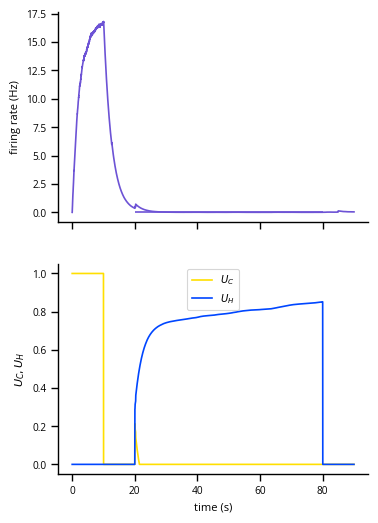

target = 1
Starting simulation at t=0. s for a duration of 90. s
10.6268 s (11%) simulated in 1m 0s, estimated 7m 28s remaining.
10.6582 s (11%) simulated in 14m 20s, estimated 1h 46m 49s remaining.
17.5906 s (19%) simulated in 15m 20s, estimated 1h 3m 11s remaining.
29.0514 s (32%) simulated in 16m 20s, estimated 34m 18s remaining.
39.4422 s (43%) simulated in 17m 20s, estimated 22m 14s remaining.
50.6342 s (56%) simulated in 18m 20s, estimated 14m 16s remaining.
60.5906 s (67%) simulated in 19m 20s, estimated 9m 24s remaining.
71.3762 s (79%) simulated in 20m 20s, estimated 5m 19s remaining.
81.9392 s (91%) simulated in 21m 20s, estimated 2m 6s remaining.
90. s (100%) simulated in 22m 4s


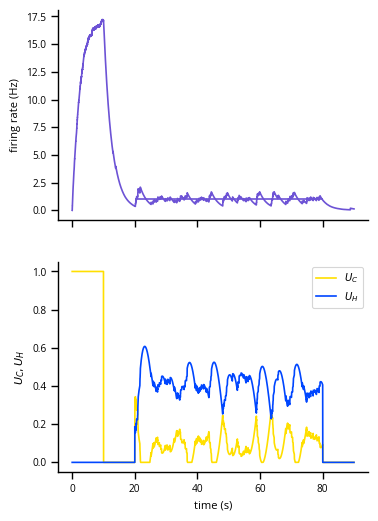

target = 2
Starting simulation at t=0. s for a duration of 90. s
10.9728 s (12%) simulated in 1m 0s, estimated 7m 12s remaining.
22.8952 s (25%) simulated in 2m 0s, estimated 5m 52s remaining.
33.4882 s (37%) simulated in 3m 0s, estimated 5m 4s remaining.
41.5942 s (46%) simulated in 16h 9m 50s, estimated 18h 48m 40s remaining.
47.0514 s (52%) simulated in 16h 10m 50s, estimated 14h 46m 11s remaining.
54.1208 s (60%) simulated in 16h 11m 50s, estimated 10h 44m 17s remaining.
61.9394 s (68%) simulated in 16h 12m 50s, estimated 7h 20m 44s remaining.
70.1462 s (77%) simulated in 16h 13m 50s, estimated 4h 35m 38s remaining.
76.6522 s (85%) simulated in 16h 14m 50s, estimated 2h 49m 45s remaining.
83.2182 s (92%) simulated in 16h 15m 50s, estimated 1h 19m 32s remaining.
89.0576 s (98%) simulated in 16h 16m 50s, estimated 10m 20s remaining.
90. s (100%) simulated in 16h 16m 56s


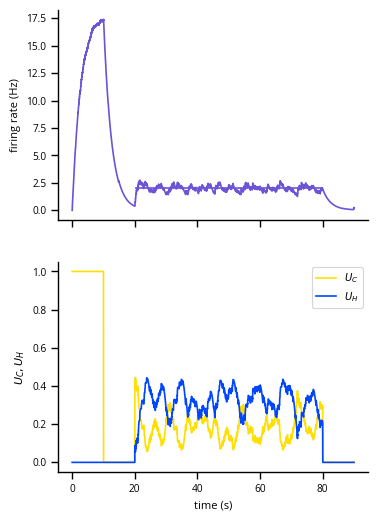

target = 3
Starting simulation at t=0. s for a duration of 90. s
9.7202 s (10%) simulated in 1m 0s, estimated 8m 16s remaining.
22.449 s (24%) simulated in 2m 0s, estimated 6m 1s remaining.
33.3262 s (37%) simulated in 3m 0s, estimated 5m 6s remaining.
42.5342 s (47%) simulated in 4m 0s, estimated 4m 28s remaining.
52.6502 s (58%) simulated in 5m 0s, estimated 3m 33s remaining.
63.0246 s (70%) simulated in 6m 0s, estimated 2m 34s remaining.
73.9446 s (82%) simulated in 7m 0s, estimated 1m 31s remaining.
84.8802 s (94%) simulated in 8m 0s, estimated 29s remaining.
90. s (100%) simulated in 8m 29s


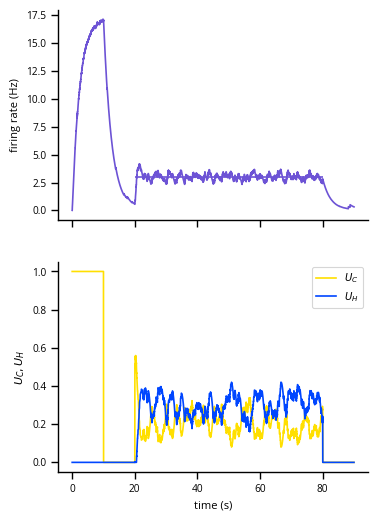

target = 4
Starting simulation at t=0. s for a duration of 90. s
9.6352 s (10%) simulated in 1m 0s, estimated 8m 20s remaining.
21.0882 s (23%) simulated in 2m 0s, estimated 6m 32s remaining.
31.527 s (35%) simulated in 3m 0s, estimated 5m 34s remaining.
41.1922 s (45%) simulated in 4m 0s, estimated 4m 44s remaining.
50.8384 s (56%) simulated in 5m 0s, estimated 3m 51s remaining.
60.0722 s (66%) simulated in 6m 0s, estimated 2m 59s remaining.
70.9104 s (78%) simulated in 7m 0s, estimated 1m 53s remaining.
81.5008 s (90%) simulated in 8m 0s, estimated 50s remaining.
90. s (100%) simulated in 8m 45s


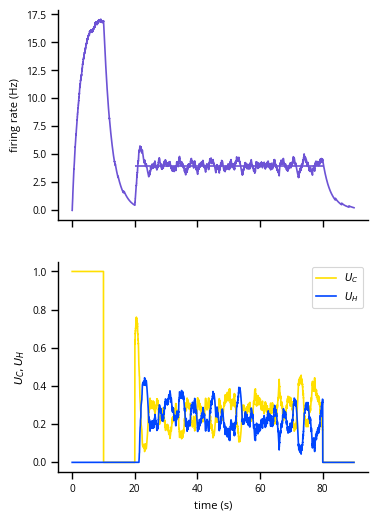

target = 5
Starting simulation at t=0. s for a duration of 90. s
9.1422 s (10%) simulated in 1m 0s, estimated 8m 51s remaining.
18.3924 s (20%) simulated in 2m 0s, estimated 7m 47s remaining.
28.3622 s (31%) simulated in 3m 0s, estimated 6m 31s remaining.
38.6964 s (42%) simulated in 4m 0s, estimated 5m 18s remaining.
48.7102 s (54%) simulated in 5m 0s, estimated 4m 14s remaining.
48.872 s (54%) simulated in 43m 2s, estimated 36m 14s remaining.
48.8938 s (54%) simulated in 52m 49s, estimated 44m 25s remaining.
54.479 s (60%) simulated in 53m 49s, estimated 35m 6s remaining.
67.2024 s (74%) simulated in 54m 49s, estimated 18m 36s remaining.
81.2042 s (90%) simulated in 55m 49s, estimated 6m 3s remaining.
87.4944 s (97%) simulated in 1h 10m 18s, estimated 2m 1s remaining.
90. s (100%) simulated in 1h 10m 33s


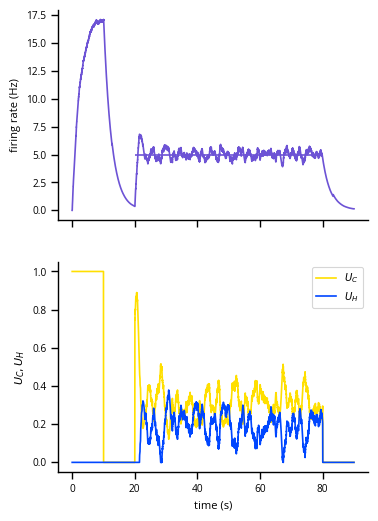

target = 6
Starting simulation at t=0. s for a duration of 90. s
15.5862 s (17%) simulated in 1m 0s, estimated 4m 46s remaining.
30.1136 s (33%) simulated in 2m 0s, estimated 3m 59s remaining.
46.7842 s (51%) simulated in 3m 0s, estimated 2m 46s remaining.
61.2762 s (68%) simulated in 4m 0s, estimated 1m 53s remaining.
73.047 s (81%) simulated in 5m 0s, estimated 1m 10s remaining.
85.5442 s (95%) simulated in 6m 0s, estimated 19s remaining.
90. s (100%) simulated in 6m 17s


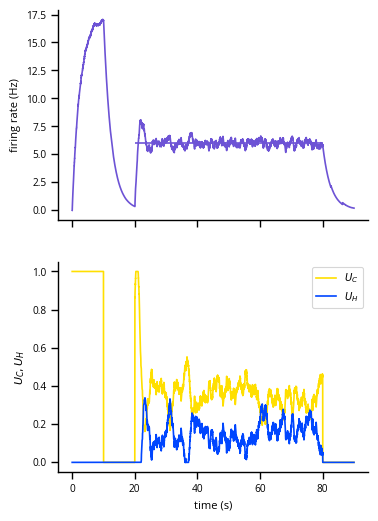

target = 7
Starting simulation at t=0. s for a duration of 90. s
14.3642 s (15%) simulated in 1m 0s, estimated 5m 16s remaining.
29.3744 s (32%) simulated in 2m 0s, estimated 4m 8s remaining.
43.629 s (48%) simulated in 3m 0s, estimated 3m 11s remaining.
57.4918 s (63%) simulated in 4m 0s, estimated 2m 16s remaining.
71.4898 s (79%) simulated in 5m 0s, estimated 1m 18s remaining.
85.2236 s (94%) simulated in 6m 0s, estimated 20s remaining.
90. s (100%) simulated in 6m 18s


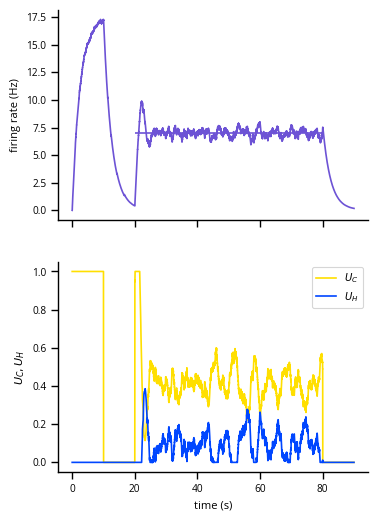

target = 8
Starting simulation at t=0. s for a duration of 90. s
13.9422 s (15%) simulated in 1m 0s, estimated 5m 27s remaining.
28.6042 s (31%) simulated in 2m 0s, estimated 4m 18s remaining.
42.4652 s (47%) simulated in 3m 0s, estimated 3m 21s remaining.
56.3154 s (62%) simulated in 4m 0s, estimated 2m 24s remaining.
69.9962 s (77%) simulated in 5m 0s, estimated 1m 26s remaining.
83.6342 s (92%) simulated in 6m 0s, estimated 27s remaining.
90. s (100%) simulated in 6m 26s


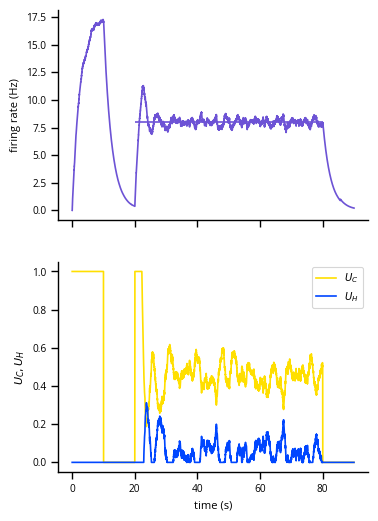

target = 9
Starting simulation at t=0. s for a duration of 90. s
12.0242 s (13%) simulated in 1m 0s, estimated 6m 29s remaining.
25.9182 s (28%) simulated in 2m 0s, estimated 4m 57s remaining.
39.8388 s (44%) simulated in 3m 0s, estimated 3m 47s remaining.
52.4668 s (58%) simulated in 4m 0s, estimated 2m 52s remaining.
65.5722 s (72%) simulated in 5m 0s, estimated 1m 52s remaining.
78.6726 s (87%) simulated in 6m 0s, estimated 52s remaining.
90. s (100%) simulated in 6m 51s


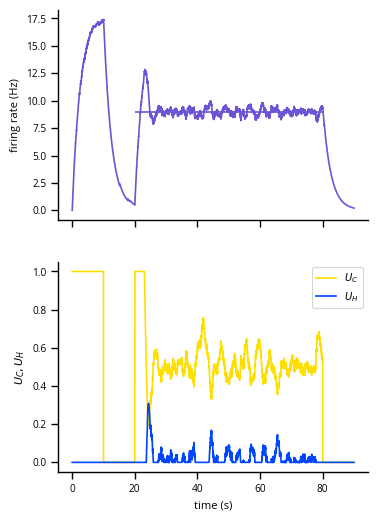

target = 10
Starting simulation at t=0. s for a duration of 90. s
14.0542 s (15%) simulated in 1m 0s, estimated 5m 24s remaining.
26.9122 s (29%) simulated in 2m 0s, estimated 4m 41s remaining.
40.66 s (45%) simulated in 3m 0s, estimated 3m 38s remaining.
54.3286 s (60%) simulated in 4m 0s, estimated 2m 38s remaining.
67.2242 s (74%) simulated in 5m 0s, estimated 1m 42s remaining.
79.6202 s (88%) simulated in 6m 0s, estimated 47s remaining.
88.6982 s (98%) simulated in 7m 0s, estimated 6s remaining.
90. s (100%) simulated in 7m 11s


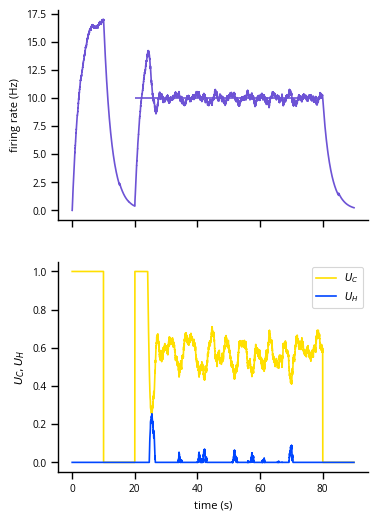

In [17]:
from IPython.display import display
import pickle
import os

targets = range(11)
# targets = [2, 3, 4, 5]
ctrlr = Controller()
for target in targets:
    filename = f"{results_path}/{target}.pkl"
    if os.path.exists(filename):
        print(f"results for target {target} already saved. skipping.")
        continue

    ctrlr = Controller()
    sim.reset()
    sim.set_io_processor(ctrlr)
    ctrlr.target = target * b2.Hz
    print(f"target = {target}")
    sim.run(ctrlr.timepoints[-1], report_period=60 * b2.second, report="text")

    results[target] = (
        ctrlr.t_samp / b2.ms,
        ctrlr.frs,
        ctrlr.UCs,
        ctrlr.UHs,
    )
    with open(filename, "wb") as file:
        pickle.dump(results[target], file)

    plot_results(*results[target], target)

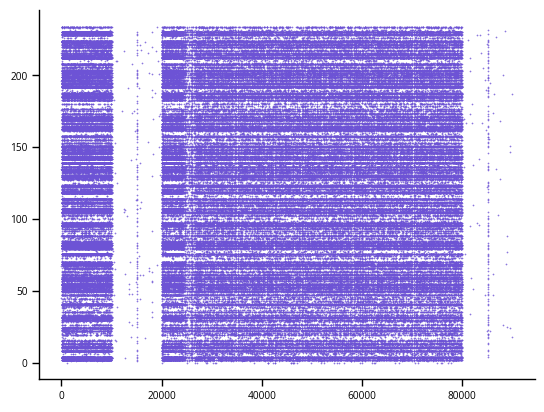

In [18]:
plt.scatter(spikes.t / b2.ms, spikes.i, marker=".", s=0.5)

## Generate final combined figure

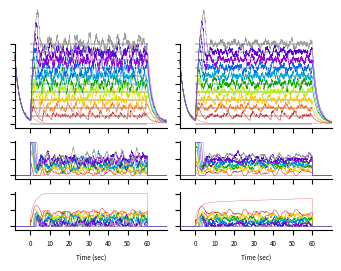

In [23]:
import matplotlib as mpl
from matplotlib import ticker


mpl.rc_file_defaults()
with plt.rc_context({"font.size": 5, "svg.fonttype": "none"}):
    fig, axs = plt.subplots(
        3,
        2,
        sharex=True,
        sharey="row",
        height_ratios=[2.22, 1, 1],
        figsize=(3.3, 2.6),
        layout="compressed",
    )
    rainbow_cycler = plt.cycler(
        color=[
            "#e56f72",
            "#cd0608",
            "#fd6b16",
            "#fdc803",
            "#b8f003",
            "#08a605",
            "#02a9d7",
            "#0169f1",
            "#9900d7",
            "#5601d5",
            "#9b9b9b",
        ]
    )
    for ax in axs.flatten():
        ax.set_prop_cycle(rainbow_cycler)

    offset_s = 20
    t_start_s = -8
    lw = 0.3

    for i_col, results_path in enumerate(["results/newman15", "results/newman15-alt"]):
        for target in targets:
            if not os.path.exists(f"{results_path}/{target}.pkl"):
                print(
                    f"results for target {target} not found in {results_path}. skipping."
                )
                continue
            with open(f"{results_path}/{target}.pkl", "rb") as file:
                t_ms, frs, UCs, UHs = pickle.load(file)
            t = np.array(t_ms) / 1000 - offset_s
            axs[0, i_col].hlines(
                target,
                ctrlr.timepoints[1] / b2.second - offset_s,
                ctrlr.timepoints[2] / b2.second - offset_s,
                color="k",
                lw=lw,
                clip_on=False,
            )
            axs[0, i_col].plot(
                t[t >= t_start_s],
                np.array(frs)[t >= t_start_s],
                clip_on=False,
                lw=lw,
                rasterized=True,
            )
            axs[0, i_col].set(
                # ylabel="Firing rate (Hz/unit)",
                ylim=[-0.5, 10],
                # yticks=range(0, 11, 1),
                # yticklabels=range(0, 11, 5),
                yticklabels=[],
            )
            axs[0, i_col].yaxis.set_major_locator(ticker.MultipleLocator(5))
            axs[0, i_col].yaxis.set_minor_locator(ticker.MultipleLocator(1))
            axs[1, i_col].plot(t, UCs, lw=lw, rasterized=True)
            axs[1, i_col].set(
                # ylabel="$U_C$",
                ylim=[-0.1, 1.05],
                yticks=[0, 0.5, 1],
                yticklabels=[],
            )
            axs[2, i_col].plot(t, UHs, lw=lw, rasterized=True)
            axs[2, i_col].set(
                # ylabel="$U_H$",
                xlabel="Time (sec)",
                ylim=[-0.1, 1.05],
                xlim=[t_start_s, max(t)],
                yticks=[0, 0.5, 1],
                yticklabels=[],
                xticks=range(0, 70, 10),
            )

    fig.savefig("img/fig/optoclamp-combined.svg", dpi=300, transparent=True)